# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [163]:
# Load pickled data
import pickle
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import os
import matplotlib.image as mpimg

training_file = '../traffic-signs-data/train.p'
validation_file= '../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [164]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

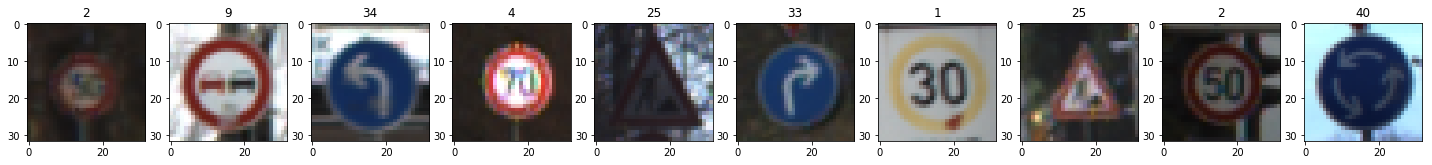

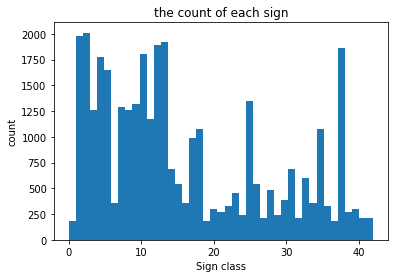

In [165]:
### Data exploration visualization code goes here.

# Visualizations will be shown in the notebook.
%matplotlib inline

#plotting traffic sign images
fig = plt.figure(figsize=(25,25))
for i in range(1,11):
    fig.add_subplot(1, 10, i) 
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    plt.imshow(image)
    plt.title(y_train[index])

#plotting the count of each sign
fig, cnt = plt.subplots()
cnt.set_title("the count of each sign")
cnt.set_xlabel("Sign class")
cnt.set_ylabel("count")
cnt.hist(y_train, n_classes)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [166]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

### grayscale data
def gray_data(data):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in data])

### Normalization data
def norm_data(data):
    return data/128 -1

X_train, y_train = shuffle(X_train, y_train)
X_train_org = X_train
X_train_norm =  norm_data(X_train_org)
X_train_gray = gray_data(X_train_org)

X_train = X_train_norm
X_valid = norm_data(X_valid)
X_test = norm_data(X_test)

#### Verified Pre-process data

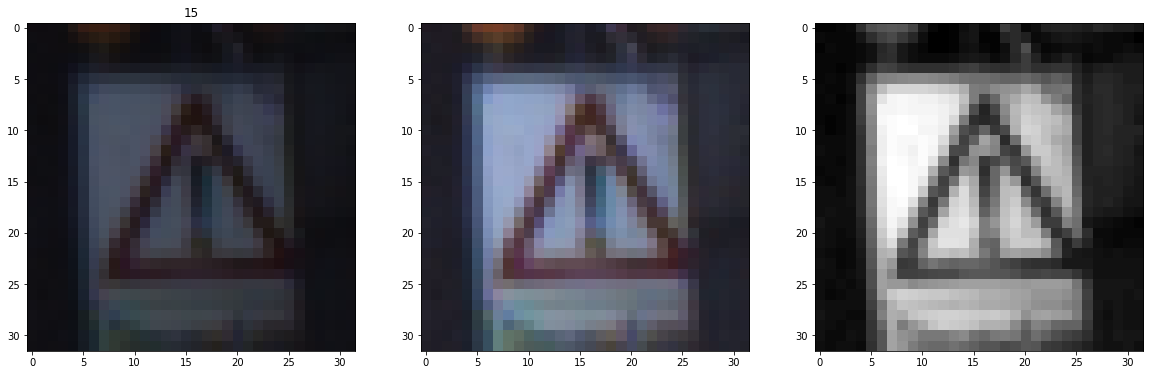

org [15 12 16]
norm [-0.8828125 -0.90625   -0.875    ]
gray 13


In [214]:
### Plot original data, normalized data, grayscale data
def plot_3_Datas(data1, data2, data3, label):
    index = random.randint(0, len(X_train))
    fig = plt.figure(figsize=(20,20))
    fig.add_subplot(1, 3, 1) 
    plt.imshow(data1[index].squeeze())
    plt.title(label[index])
    fig.add_subplot(1, 3, 2) 
    plt.imshow(data2[index])
    fig.add_subplot(1, 3, 3) 
    plt.imshow(data3[index], cmap='gray')
    plt.show()
    print ('org',data1[index][0][0])
    print ('norm',data2[index][0][0])
    print ('gray',data3[index][0][0])
    
plot_3_Datas(X_train_org, X_train_norm, X_train_gray, y_train)    

### Split Data into Training, Validation and Testing Sets

In [168]:
### Split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
#from sklearn.model_selection import train_test_split
#X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

### Model Architecture

In [169]:
### Define your architecture here.
# Parameters
EPOCHS = 10
BATCH_SIZE = 128
dropout = 0.5
mu = 0
sigma = 0.1

weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma)),
    'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
    'wd1': tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma)),
    'wd2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)),        
    'out': tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))}

biases = {
    'bc1': tf.Variable(tf.zeros(6)),
    'bc2': tf.Variable(tf.zeros(16)),
    'bd1': tf.Variable(tf.zeros(120)),
    'bd2': tf.Variable(tf.zeros(84)),
    'out': tf.Variable(tf.zeros(43))}

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

def LeNet(x, weights, biases, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer  
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Activation.
    conv1   = conv2d(x, weights['wc1'], biases['bc1'])   
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1, k=2)
    # Layer 2: Convolutional. Output = 10x10x16.
    # Activation.
    conv2   = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2, k=2)
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)  
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1   = tf.add(tf.matmul(fc0, weights['wd1']), biases['bd1'])
    # Activation.
    fc1    = tf.nn.relu(fc1)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2    = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])  
    # Activation.
    fc2    = tf.nn.relu(fc2)
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [170]:
# tf Graph input
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) 
one_hot_y = tf.one_hot(y, 43) 

#Training Pipeline
rate = 0.001

# Model
logits = LeNet(x, weights, biases, keep_prob)

# Define loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Class used to save and/or restore Tensor Variables
saver = tf.train.Saver()

# Model Evaluation
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0 })
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples  
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

#### Train the Model

In [171]:
### Train model here.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.729

EPOCH 2 ...
Validation Accuracy = 0.848

EPOCH 3 ...
Validation Accuracy = 0.889

EPOCH 4 ...
Validation Accuracy = 0.881

EPOCH 5 ...
Validation Accuracy = 0.901

EPOCH 6 ...
Validation Accuracy = 0.919

EPOCH 7 ...
Validation Accuracy = 0.923

EPOCH 8 ...
Validation Accuracy = 0.927

EPOCH 9 ...
Validation Accuracy = 0.933

EPOCH 10 ...
Validation Accuracy = 0.939

Model saved


#### Test the Model

In [172]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.920


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

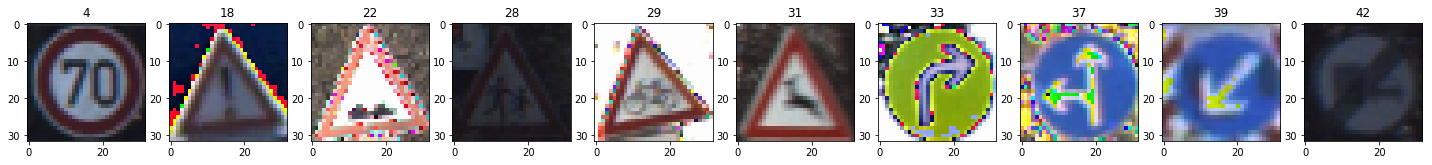

In [202]:
### Load the images and plot them here.

### Load image and resize to 32x32
def load_image(dir):
    return np.array([cv2.resize(mpimg.imread(dir + image), (32, 32)) for image in os.listdir(dir)])
### Plot image and label    
def plot_image(x,y):
    fig = plt.figure(figsize=(25,25))
    for idx, image in enumerate(x):
        fig.add_subplot(1, len(x), idx+1)
        plt.title(y[idx])
        plt.imshow(image) 
        
new_dataset = load_image("my_images/")
new_labels = np.array([4, 18, 22, 28, 29, 31, 33, 37, 39, 42])
#preprocess data for new images
new_dataset = norm_data(new_dataset)
#print (new_dataset.shape,X_test.shape)
plot_image(new_dataset, new_labels)
new_dataset, new_labels = shuffle(new_dataset, new_labels)

### Predict the Sign Type for Each Image

In [203]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.

### Top 5 Softmax Probabilities 
top5 = tf.nn.top_k(tf.nn.softmax(logits), k=5, sorted=True, name=None)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top5_pred = sess.run(top5, feed_dict={x: new_dataset, keep_prob: 1.0})
    top5_prob = top5_pred[0]
    top5_indices = top5_pred[1]
    
    test_accuracy = evaluate(new_dataset, new_labels)
    print("New Images Accuracy = {:.3f}".format(test_accuracy))
#print (top5_prob)
#print (top5_indices)

New Images Accuracy = 0.900


### Analyze Performance

In [208]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
cnt = 0
for idx in range(len(new_labels)):
    print ('New image class = ',new_labels[idx], ', and the model predict class = ', top5_indices[idx][0])
    if new_labels[idx] == top5_indices[idx][0]:
        print ('Success predict the traffic sign!!!')
        cnt += 1
    else:
        print ('Failed on predict the traffic sign...')
    print ()
print ()    
print ('Total Accuracy of New Images = ', cnt/len(top5_prob))    

New image class =  18 , and the model predict class =  18
Success predict the traffic sign!!!

New image class =  39 , and the model predict class =  39
Success predict the traffic sign!!!

New image class =  33 , and the model predict class =  33
Success predict the traffic sign!!!

New image class =  22 , and the model predict class =  22
Success predict the traffic sign!!!

New image class =  29 , and the model predict class =  29
Success predict the traffic sign!!!

New image class =  28 , and the model predict class =  23
Failed on predict the traffic sign...

New image class =  37 , and the model predict class =  37
Success predict the traffic sign!!!

New image class =  31 , and the model predict class =  31
Success predict the traffic sign!!!

New image class =  42 , and the model predict class =  42
Success predict the traffic sign!!!

New image class =  4 , and the model predict class =  4
Success predict the traffic sign!!!


Total Accuracy of New Images =  0.9


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [211]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
for idx in range(len(top5_prob)):
    print ('New images:', new_labels[idx])
    print ('Top five indices class = ', top5_indices[idx])
    print ('Top five Softmax Probabilities  = ', top5_prob[idx])   
    print ()    


New images: 18
Top five indices class =  [18 26 27 24  4]
Top five Softmax Probabilities  =  [  9.94917989e-01   5.04277740e-03   3.39878534e-05   3.51793051e-06
   1.30233093e-06]

New images: 39
Top five indices class =  [39 40  4 37  1]
Top five Softmax Probabilities  =  [  9.94427443e-01   2.98934244e-03   1.57480489e-03   7.88259029e-04
   1.33568101e-04]

New images: 33
Top five indices class =  [33 35 19  9 11]
Top five Softmax Probabilities  =  [  9.99999762e-01   2.08704705e-07   7.40288719e-09   6.11698026e-09
   5.53348700e-09]

New images: 22
Top five indices class =  [22 25 29 26 24]
Top five Softmax Probabilities  =  [  9.97682214e-01   2.31388840e-03   3.66383051e-06   2.09527968e-07
   4.51214427e-10]

New images: 29
Top five indices class =  [29 28 22 15 20]
Top five Softmax Probabilities  =  [ 0.60529882  0.30574116  0.06099238  0.02503244  0.00188213]

New images: 28
Top five indices class =  [23 25 20 29  3]
Top five Softmax Probabilities  =  [ 0.22611067  0.1872031

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 